# Regression from ch 4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
import pandas as pd

%matplotlib inline
sns.set(font_scale=1.5)

Text(0.5, 0, '$y$')

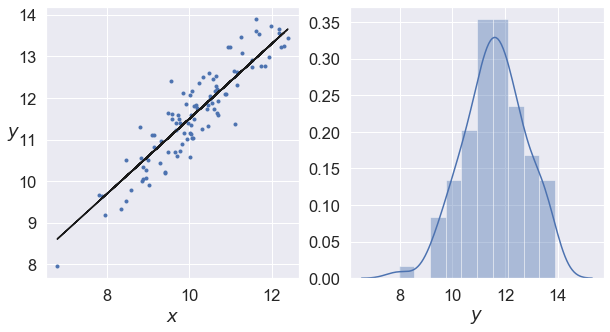

In [2]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', )
plt.ylabel('$y$', rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.distplot(y)
plt.xlabel('$y$')

In [3]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3524.83draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


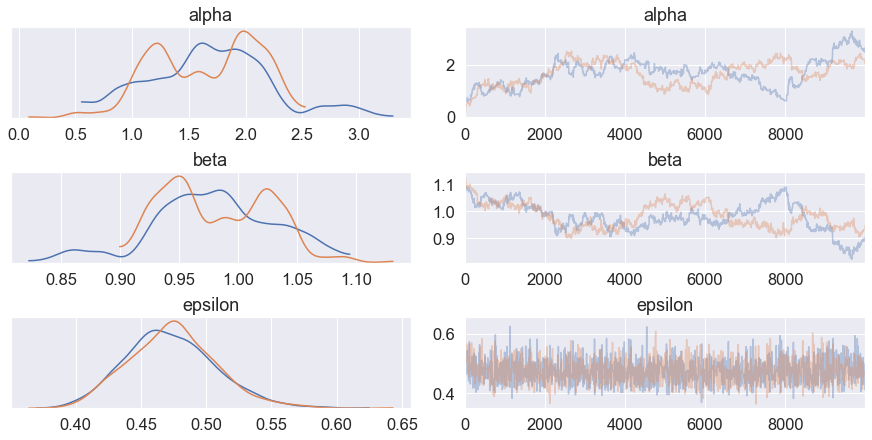

In [4]:
pm.traceplot(trace, compact=True);

### This slow wandering in alpha and beta shows an issue!

In [5]:
pm.summary(trace, var_names=('alpha', 'beta', 'epsilon'))

/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.669461,0.503898,0.049108,0.581843,2.479340,17.580114,1.001585
beta,0.980660,0.049421,0.004812,0.904448,1.090076,17.622857,1.001567
epsilon,0.473785,0.033953,0.000954,0.410031,0.541577,1324.606066,1.000454


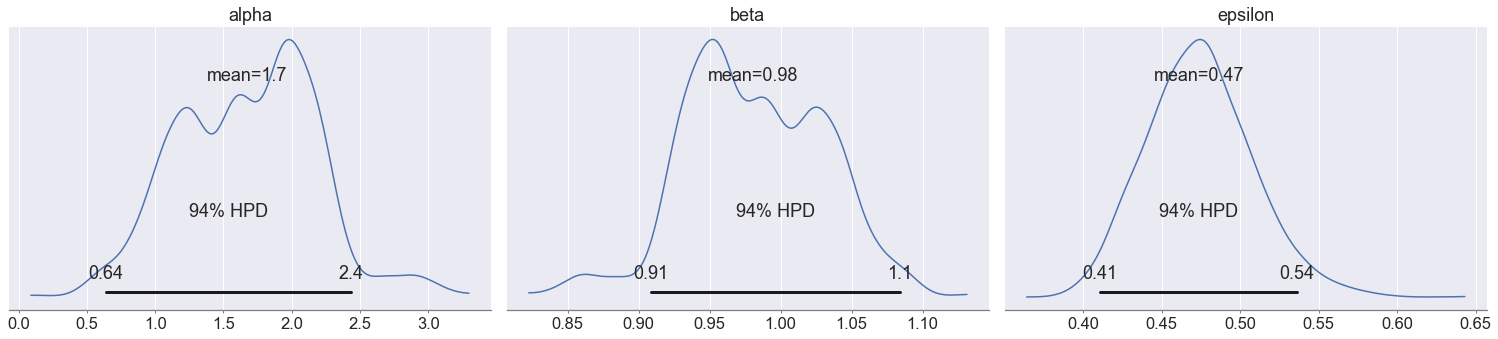

In [6]:
pm.plot_posterior(trace, var_names=('alpha', 'beta', 'epsilon'));

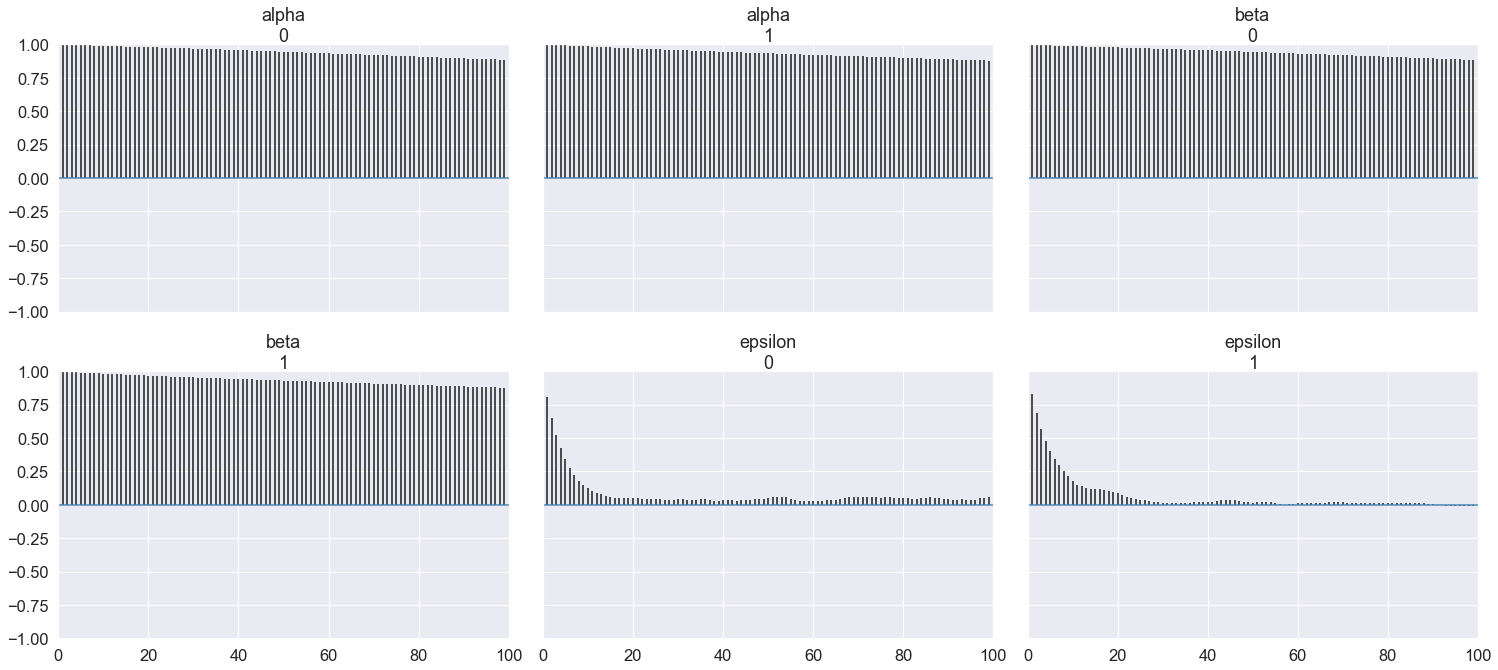

In [7]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

Text(0, 0.5, '$\\beta$')

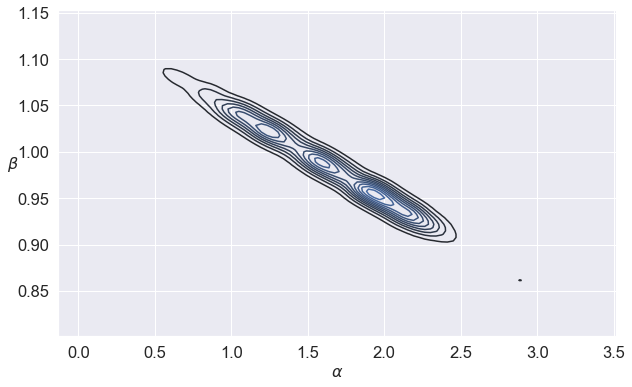

In [8]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

## Does NUTS do better?

In [9]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3501.51draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


### No!

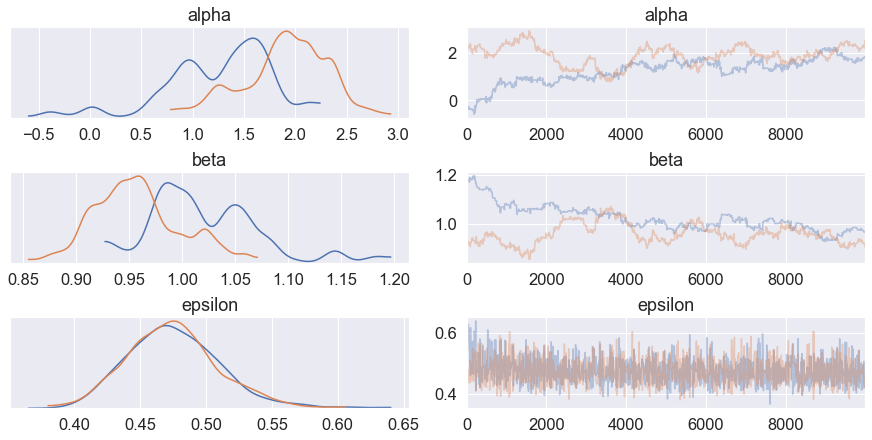

In [10]:
pm.traceplot(trace, compact=True);

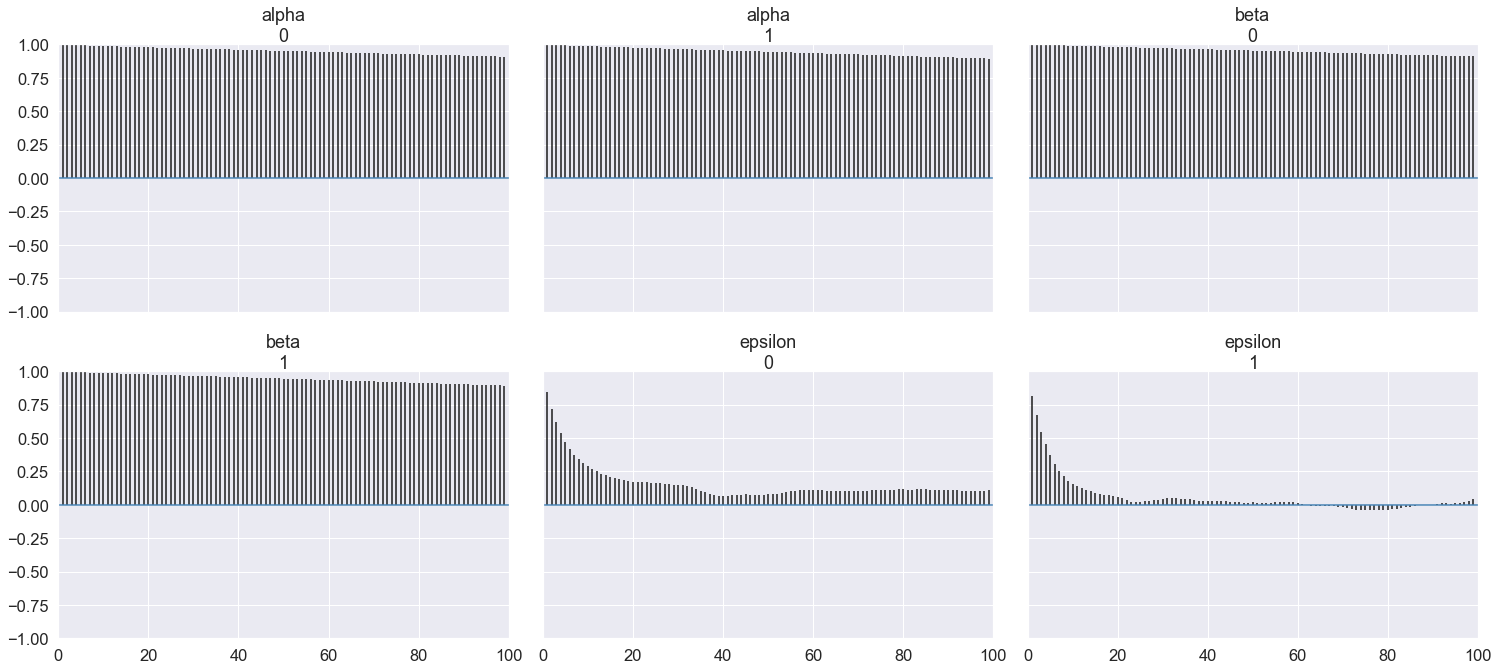

In [11]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

Text(0, 0.5, '$\\beta$')

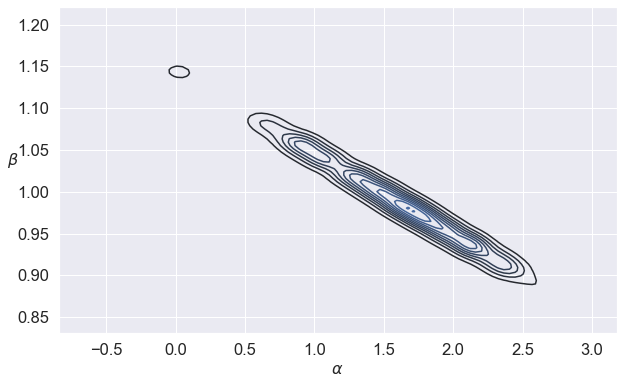

In [12]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### Try subtracting the mean

In [13]:
xmean = np.mean(x)
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * (x-xmean), sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 4030.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


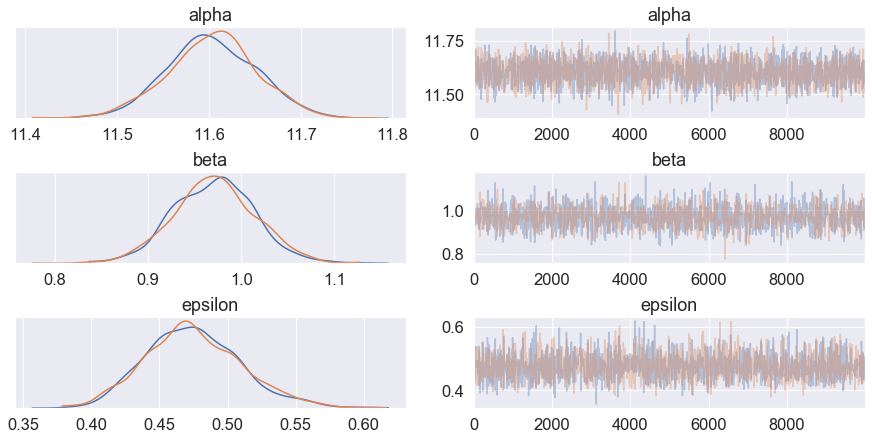

In [14]:
pm.traceplot(trace, compact=True);

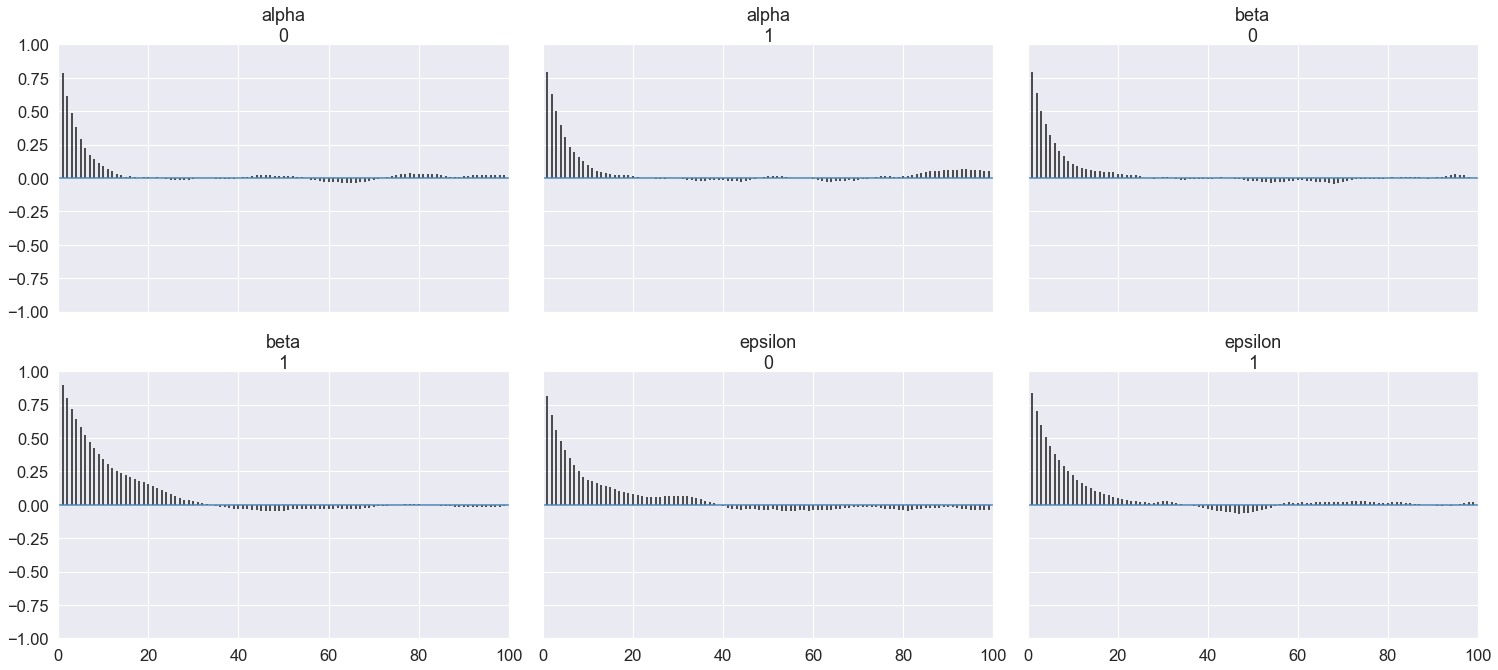

In [15]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

Text(0, 0.5, '$\\beta$')

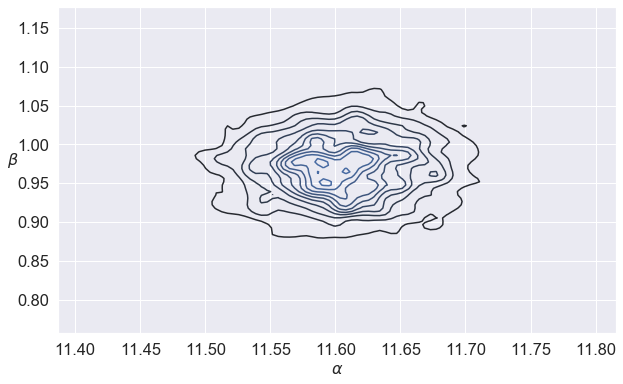

In [16]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

In [17]:
pm.plot_ppc(trace)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

No handles with labels found to put in legend.


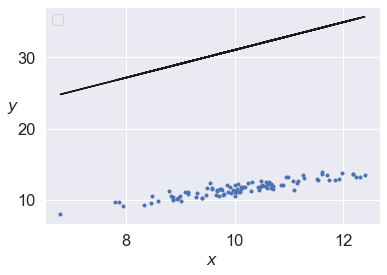

In [18]:
plt.plot(x, y, 'b.');
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
alpha = alpha_m+beta_m*x
plt.plot(x, alpha + beta_m * x, c='k', ) #label='y = {:.2f} + {:.2f} * x'.format(alpha, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

In [19]:
alpha

array([21.49508333, 19.82474454, 21.23177486, 21.32659351, 21.95495393,
       21.93435498, 21.43237385, 23.42436192, 21.34371535, 21.87061839,
       20.21544423, 20.28211827, 23.18564877, 20.48234527, 21.09017368,
       23.00573641, 22.53537113, 22.23721106, 20.8160578 , 21.31788031,
       21.32155406, 20.80420462, 23.10390306, 20.86835663, 21.96045031,
       23.43829159, 21.78590637, 21.93484856, 21.79333332, 20.73616154,
       22.15030014, 20.98139877, 21.85697658, 21.74203915, 22.17959849,
       22.878267  , 20.20130632, 21.35329095, 21.4087529 , 21.2513884 ,
       21.12975175, 20.99999018, 21.000403  , 20.61773239, 20.9130233 ,
       19.17482095, 22.26387443, 21.98972029, 21.72349053, 21.10087263,
       23.63876104, 19.31444467, 21.19646003, 20.17835629, 21.05003008,
       19.81038872, 20.34067035, 21.60106187, 20.64558076, 21.02971606,
       21.46672562, 21.17343396, 22.79736914, 21.07586597, 23.48228219,
       21.95704731, 21.34991234, 20.42759987, 20.35338662, 21.62

In [20]:
alpha, beta_m

(array([21.49508333, 19.82474454, 21.23177486, 21.32659351, 21.95495393,
        21.93435498, 21.43237385, 23.42436192, 21.34371535, 21.87061839,
        20.21544423, 20.28211827, 23.18564877, 20.48234527, 21.09017368,
        23.00573641, 22.53537113, 22.23721106, 20.8160578 , 21.31788031,
        21.32155406, 20.80420462, 23.10390306, 20.86835663, 21.96045031,
        23.43829159, 21.78590637, 21.93484856, 21.79333332, 20.73616154,
        22.15030014, 20.98139877, 21.85697658, 21.74203915, 22.17959849,
        22.878267  , 20.20130632, 21.35329095, 21.4087529 , 21.2513884 ,
        21.12975175, 20.99999018, 21.000403  , 20.61773239, 20.9130233 ,
        19.17482095, 22.26387443, 21.98972029, 21.72349053, 21.10087263,
        23.63876104, 19.31444467, 21.19646003, 20.17835629, 21.05003008,
        19.81038872, 20.34067035, 21.60106187, 20.64558076, 21.02971606,
        21.46672562, 21.17343396, 22.79736914, 21.07586597, 23.48228219,
        21.95704731, 21.34991234, 20.42759987, 20.3

# Look to problmatic data sets
page 114+


In [23]:
ans = sns.load_dataset?
# x_3 = ans[ans.dataset == 'III']['x'].values
# y_3 = ans[ans.dataset == 'III']['y'].values

In [165]:
X = np.arange(10)+np.random.normal(0, .1, size=10)
Y = 5*X + 10 + np.random.normal(0, 3, size=10)
Y[7] += 50

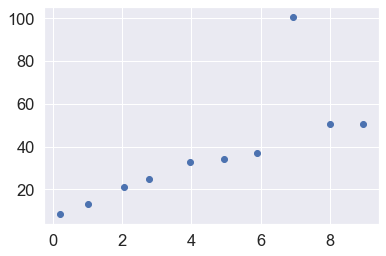

In [166]:
plt.scatter(X,Y)

In [167]:
data = pd.DataFrame({'x':X, 'y':Y})
with pm.Model() as model:
    glm_n = pm.glm.GLM.from_formula('y ~ x', data)
    trace_n = pm.sample(2000) # draw 2000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1336.23draws/s]


In [168]:
glm_n

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b1c2b90>,
      dtype=object)

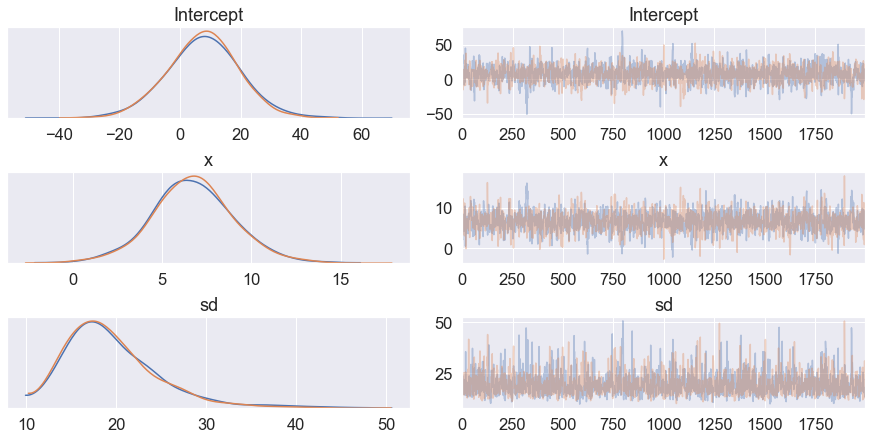

In [169]:
pm.traceplot(trace_n)

In [170]:
ppc_n = pm.sample_posterior_predictive(trace_n, samples=500, model=model, )


100%|██████████| 500/500 [00:00<00:00, 1033.41it/s]


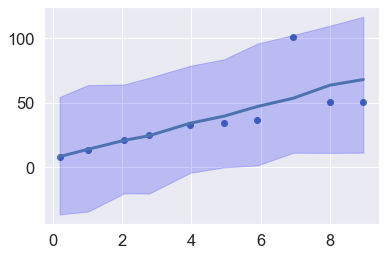

In [171]:
plt.scatter(X,Y)
perc_n = np.percentile(ppc_n['y'], [2.5, 97.5, 50], axis=0)
plt.fill_between(X, perc_n[0], perc_n[1], color='blue', alpha=0.2)
plt.plot(X, perc_n[2], lw=3)

In [192]:
data = pd.DataFrame({'x':X, 'y':Y})
with pm.Model() as model:
    glm_t = pm.glm.GLM.from_formula('y ~ x', data, family=pm.families.StudentT())
    step = pm.Metropolis()
#     step = pm.NUTS()
    trace_t = pm.sample(10000, step=step, tune=5000) # draw 2000 posterior samples using NUTS sampling

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [lam]
>Metropolis: [x]
>Metropolis: [Intercept]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:06<00:00, 4729.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


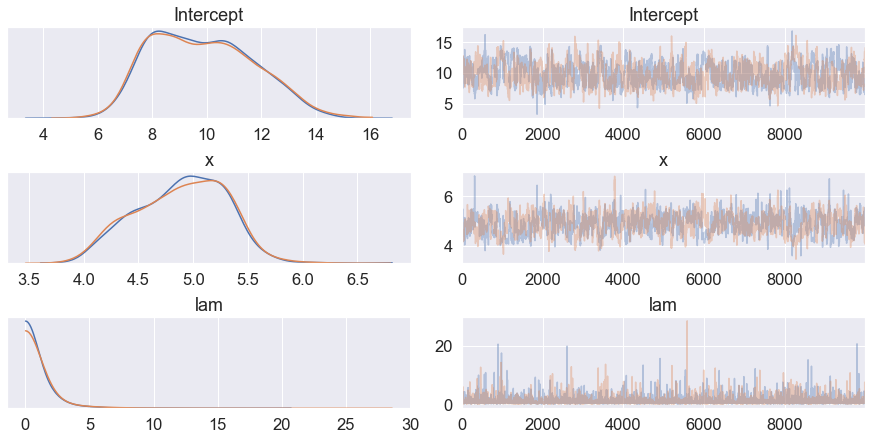

In [193]:
pm.traceplot(trace_t);

In [194]:
pm.summary(trace_t)

/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,9.865723,1.850642,0.096137,6.993745,13.551182,321.494755,0.999976
x,4.894053,0.406088,0.020731,4.079527,5.522325,333.364875,0.999970
lam,1.146886,1.433899,0.025639,0.039177,3.573264,3107.392248,1.000550


In [195]:
glm_t

100%|██████████| 1000/1000 [00:00<00:00, 1195.70it/s]


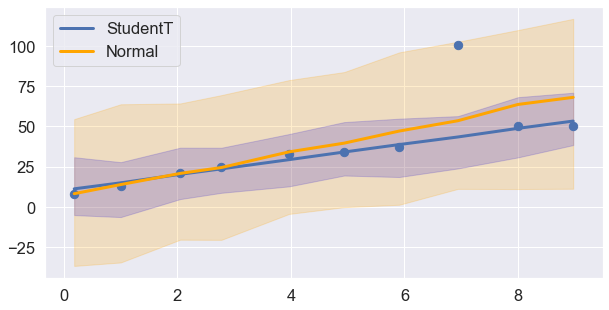

In [198]:
fig, ax = plt.subplots(figsize=(10,5))

ppc_t = pm.sample_posterior_predictive(trace_t, samples=1000, model=model, )
perc_t = np.percentile(ppc_t['y'], [2.5, 97.5, 50], axis=0)
plt.fill_between(X, perc_t[0], perc_t[1], color='blue', alpha=0.2)
plt.fill_between(X, perc_n[0], perc_n[1], color='orange', alpha=0.2)

plt.plot(X, perc_t[2], lw=3, label='StudentT')
plt.plot(X, perc_n[2], lw=3, label='Normal', color='orange')
plt.scatter(X,Y, s=70)
plt.legend(loc='upper left')

In [200]:
pm.sample_posterior_predictive?